In [667]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [930]:
# System imports
import sys
import importlib
from pathlib import Path

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.data',
    'iowa_dream.utils',
    'iowa_dream.feature_engineering',
    'iowa_dream.feature_engineering.add_features',
    'iowa_dream.utils.plotting_EDA',
    'iowa_dream.feature_engineering.categotical_transformer',
    'iowa_dream.feature_engineering.numerical_transformer',
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader
from iowa_dream.utils.sample_split import create_sample_split
from iowa_dream.utils.describer import (
    categorical_describer,
    numerical_describer, 
    analyze_categorical_sparsity
)
from iowa_dream.utils.plotting_EDA import (
    plot_missing_data_heatmap,
    box_plot_dist,
    output_distribution_plotting,
    plot_target_over_time,
    plot_feature_distributions_interactive,
    plot_feature_target_relationships_interactive,
    plot_price_vs_sale_condition,
    plot_cramer_v_associations,
    anova_categorical_feature_importance,
    plot_numerical_correlation_matrix,
    plot_numerical_correlation_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from glum import GeneralizedLinearRegressor, GeneralizedLinearRegressorCV
from iowa_dream.feature_engineering.lot_frontage_imputer import *
from iowa_dream.feature_engineering.add_features import *
from iowa_dream.feature_engineering.categotical_transformer import *
from iowa_dream.feature_engineering.numerical_transformer import *


In [669]:
# Example usage
data_file = project_root / load_config()['kaggle']['cleaned_path'] / 'cleaned_AmesHousing.csv'
df = preliminary_loader(data_file)

In [729]:
df = create_sample_split(df, 'pid')
train_df = df[df['sample'] == 'train']
test_df = df[df['sample'] == 'test']
y = df['saleprice']

# Separate features (X) and target (y)
X_train = train_df.drop(['saleprice', 'sample', 'pid'], axis=1)
y_train = train_df['saleprice']
X_test = test_df.drop(['saleprice', 'sample', 'pid'], axis=1)
y_test = test_df['saleprice']

In [730]:
# Extract feature column names for different data types
config = load_config()
data_dict = config['data_dict']
preliminary_dropped_features = config['preliminary_dropped_features']

# Extract column lists for each data type, excluding dropped features
ordinal = [col for col in data_dict['ordinal_columns']['columns'] 
          if col in df.columns and col not in preliminary_dropped_features]
nominal = [col for col in data_dict['nominal_columns']['columns']
          if col in df.columns and col not in preliminary_dropped_features] 
continuous = [col for col in data_dict['continuous_columns']['columns']
             if col in df.columns and col not in preliminary_dropped_features]
discrete = [col for col in data_dict['discrete_columns']['columns'] 
           if col in df.columns and col not in preliminary_dropped_features]

# Check if df has any columns other than ordinal, nominal, continuous, and discrete
all_defined_columns = set(ordinal + nominal + continuous + discrete)
extra_columns = set(df.columns) - all_defined_columns
if extra_columns:
    print(f"Warning: The following columns are not classified as ordinal, nominal, continuous, or discrete: {extra_columns}")

# Create mapping of neighborhoods to their university proximity category
proximity_data = {
    neighborhood: group['category'] 
    for group in config['university_proximity']
    for neighborhood in group['neighborhoods']
}


In [732]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, r2_score
import pandas as pd
import numpy as np

def reevaluate_models(models, X, y):
    results = {
        'Model': [],
        'MAE': [],
        'RMSE': [],
        'MAPE': [],
        'MedAE': [],
        'R-squared': []
    }
    
    for model in models:
        y_pred = model.predict(X)
        
        results['Model'].append(model.__class__.__name__)
        results['MAE'].append(mean_absolute_error(y, y_pred))
        results['RMSE'].append(np.sqrt(mean_squared_error(y, y_pred)))
        results['MAPE'].append(mean_absolute_percentage_error(y, y_pred))
        results['MedAE'].append(median_absolute_error(y, y_pred))
        results['R-squared'].append(r2_score(y, y_pred))
    
    results_df = pd.DataFrame(results)
    results_df.set_index('Model', inplace=True)
    return results_df.style.format({
        'MAE': '{:.2f}',
        'RMSE': '{:.2f}',
        'MAPE': '{:.2%}',
        'MedAE': '{:.2f}',
        'R-squared': '{:.2f}'
    }).highlight_min(subset=['MAE', 'RMSE', 'MAPE', 'MedAE'], color='lightgreen').highlight_max(subset=['R-squared'], color='lightgreen').set_caption("Model Evaluation Metrics")


In [824]:
numerical_after_adding_new = list(set(continuous + discrete + ['pct_half_bath', 'timing_remodel_index', 'total_area', 'pct_finished_bsmt_sf', 'ground_sf']) - set(["total_bsmt_sf", "1st_flr_sf", "bsmtfin_sf_1"]))
nominal_after_adding_new = nominal + ['university_proximity_category']
ordinal_after_adding_new = ordinal + ['interior_quality_score', 'exterior_quality_score', '_Unfinished', 'neighborhood_score']

In [825]:
# Define the column transformer for encoding categorical variables
categorical_encoder = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore', drop='first'), nominal_after_adding_new + ordinal_after_adding_new)
    ],
    remainder='passthrough'
)

# Define the pipeline steps for imputation
impute_pipeline = Pipeline(steps=[
    ('lot_frontage_imputer', GroupMedianImputer(group_cols=['neighborhood', 'lot_config'], target_col='lot_frontage'))
])

# Define the pipeline steps for adding and dropping features
add_pipeline = Pipeline(steps=[
    ('add_numerical', AddAttributes_Numerical(add_attributes=True)),
    ('add_ordinal', AddAttributes_Ordinal(add_attributes=True, proximity_data=proximity_data)),
])
# Combine imputation and add/drop steps into the base pipeline
base_pipeline = Pipeline(steps=[
    ('impute', impute_pipeline),
    ('add', add_pipeline)
])

# Fit and transform the data with the base pipeline
X_train_preprocessed = base_pipeline.fit_transform(X_train.copy())

# Apply the encoder to the transformed data
X_train_preprocessed_encoded = categorical_encoder.fit_transform(X_train_preprocessed)

In [968]:
# Fit the Generalized Linear Regressor
base_GLM_model = GeneralizedLinearRegressor(
    family="gamma",
    l1_ratio=0.5,
    fit_intercept=True,
    link='log'
)
base_GLM_model.fit(X_train_preprocessed_encoded, y_train)
reevaluate_models([base_GLM_model], X_train_preprocessed_encoded, y_train)

,MAE,RMSE,MAPE,MedAE,R-squared
Model,,,,,
GeneralizedLinearRegressor,49969.23,69876.69,31.78%,37291.80,0.26


In [947]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class InteractionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs):
        """
        Custom transformer for generating interaction terms.
        interaction_pairs: List of tuples specifying column pairs for interaction.
        """
        self.interaction_pairs = interaction_pairs
        self.interaction_columns = []

    def fit(self, X, y=None):
        # Store the feature names during fit
        self.feature_names_ = X.columns if isinstance(X, pd.DataFrame) else [f"feature_{i}" for i in range(X.shape[1])]
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        X_transformed = pd.DataFrame(X, columns=self.feature_names_)
        
        # Create interaction terms
        for col1, col2 in self.interaction_pairs:
            interaction_col = f"{col1}_x_{col2}"
            X_transformed[interaction_col] = X_transformed[col1] * X_transformed[col2]
            self.interaction_columns.append(interaction_col)
        
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        # Return the updated feature names
        return self.feature_names_ + self.interaction_columns


In [982]:
# Define interaction function for FunctionTransformer
def add_interaction_features(X):
    """
    Adds interaction terms: 
    - 'total_area' x 'overall_qual'
    - 'total_area' x one-hot encoded 'neighborhood'
    """
    X = X.copy()
    X['interaction_total_area_overall_qual'] = X['total_area'] * X['overall_qu']
    X['timing_remodel_index_x_neighborhood_score'] = X['timing_remodel_index'] * X['neighborhood_score']
    
    return X

# Interaction pipeline
interaction_pipeline = Pipeline([
    ('interaction_creator', FunctionTransformer(add_interaction_features, validate=False))
])

# Define pipelines for nominal columns
nominal_pipeline = Pipeline([
    ('nominal_transformer', NominalTransformer()),  
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Define pipelines for ordinal columns
ordinal_pipeline = Pipeline([
    ('ordinal_merger', OrdinalMerger(min_obs=2)),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Define pipeline for spline transformation on numerical columns
spline_pipeline = Pipeline([
    ('spline_transformer', SplineTransformer(n_knots=2, degree=3, include_bias=False))
])

# Combine all pipelines using ColumnTransformer
processor_pipeline = Pipeline([
    ('interaction_pipeline', interaction_pipeline),  # Add interactions first
    ('column_transformer', ColumnTransformer(transformers=[
        ('nominal_pipeline', nominal_pipeline, nominal_after_adding_new),
        ('numerical_scaler', CustomMinMaxScaler(skew_aware=True, skew_threshold=0.95), numerical_after_adding_new),
        ('ordinal_pipeline', ordinal_pipeline, ordinal_after_adding_new),
        ('spline_total_area', spline_pipeline, ['total_area']),
        ('spline_lot_area', spline_pipeline, ['lot_area']),
    ], remainder='passthrough'))
])

# Fit and transform the data
X_train_processed = processor_pipeline.fit_transform(X_train_preprocessed)


In [994]:
from sklearn.linear_model import Ridge

# Create feature list
features = ['lot_area', 'overall_qu', 'year_blt', 'gr_liv_area', 'garage_cars', 'total_bsmt_sf']

GLM_2nd_model = GeneralizedLinearRegressor(family='gamma', link='log', l1_ratio=0.5, fit_intercept=True)
GLM_2nd_model.fit(X_train[features], y_train)
reevaluate_models([GLM_2nd_model], X_train[features], y_train)

,MAE,RMSE,MAPE,MedAE,R-squared
Model,,,,,
GeneralizedLinearRegressor,18812.85,26769.78,11.60%,13580.34,0.89


In [983]:
# Fit the Generalized Linear Regressor
GLM_2nd_model = GeneralizedLinearRegressor(family='gamma', link='log', l1_ratio=0.5, fit_intercept=True)
GLM_2nd_model.fit(X_train_processed, y_train)
reevaluate_models([GLM_2nd_model], X_train_processed, y_train)

,MAE,RMSE,MAPE,MedAE,R-squared
Model,,,,,
GeneralizedLinearRegressor,52873.37,73116.49,33.88%,40452.39,0.19


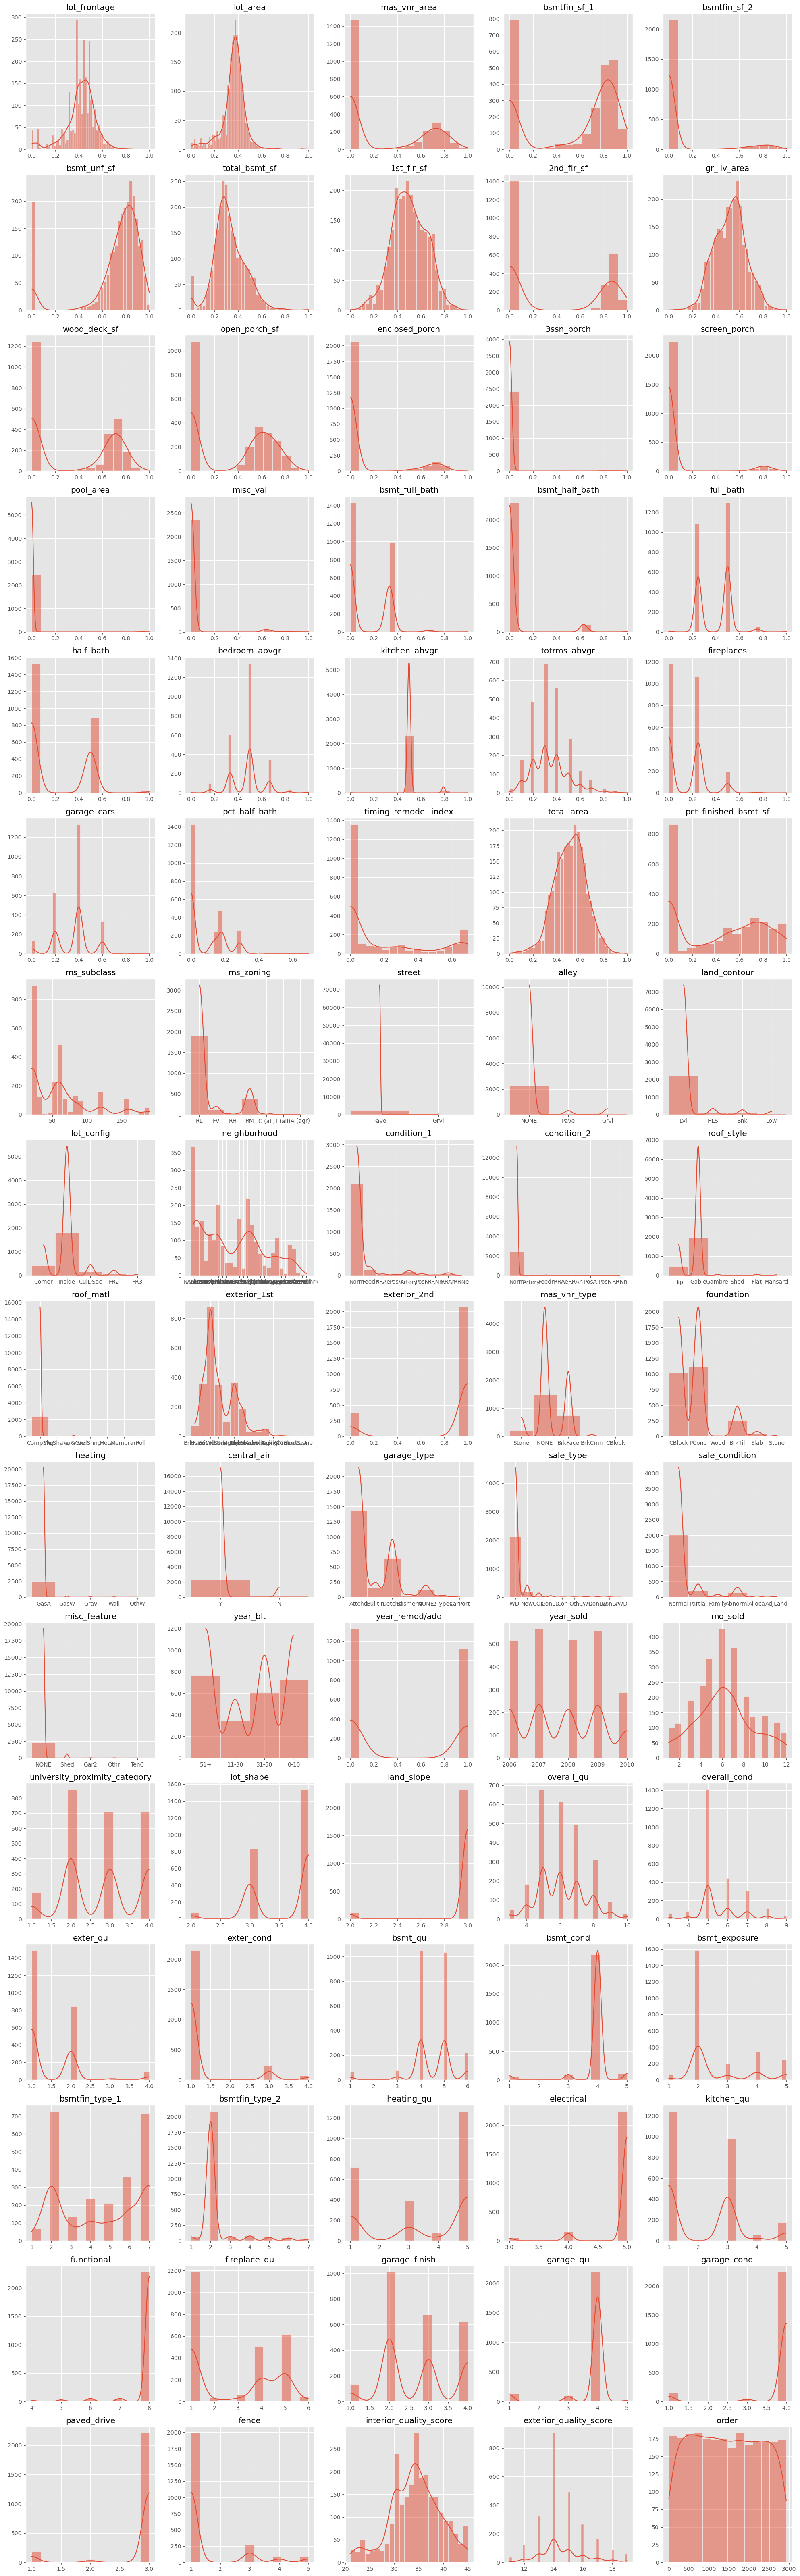

In [352]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of columns in df_transformed, 5 plots per row
num_columns = len(.columns)
num_plots_per_row = 5
num_rows = (num_columns + num_plots_per_row - 1) // num_plots_per_row

plt.figure(figsize=(20, num_rows * 4))

for i, column in enumerate(df_transformed.columns, 1):
    plt.subplot(num_rows, num_plots_per_row, i)
    sns.histplot(df_transformed[column], kde=True)
    plt.title(f'{column}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()



In [354]:
neighborhood_columns = [col for col in df_transformed.columns if col.startswith('neighborhood_')]
# Add interaction terms between 'gr_liv_area' and 'overall_qu', and 'gr_liv_area' and 'ms_subclass'
df_transformed['interaction_gr_liv_area_overall_qu'] = df_transformed['gr_liv_area'] * df_transformed['overall_qu']
print(df_transformed['interaction_gr_liv_area_overall_qu'])
for col in neighborhood_columns:
    df_transformed[f'interaction_gr_liv_area_{col}'] = df_transformed['gr_liv_area'] * df_transformed[col]
    print(df_transformed[f'interaction_gr_liv_area_{col}'])

0        3.51041
1       2.676983
2       4.127051
3        1.64435
4        2.95979
          ...   
2441    3.014124
2442    2.120794
2443    1.809811
2444    2.558593
2445    4.646721
Name: interaction_gr_liv_area_overall_qu, Length: 2446, dtype: object
